# Word Cloud 시각화

## Word Cloud 시각화 함수 만들기
 - 마켓별 리뷰를 모은 리스트를 전달받아 한번에 word cloud로 만들어주는 함수 
 - 윈도우 사용자는 C:\windows\Fonts 디렉토리에서 원하는 폰트 지정 (font_path 변수)

- 공통 변수 선언

In [2]:
import os 

PROJ_HOME = '\\'.join(os.getcwd().split('\\')[0:-1])
MARK_LST_CSV = f'{PROJ_HOME}\\crawled_files\\market_master.csv'
TFIDF_DIR = f'{PROJ_HOME}\\tfidf_files'

In [9]:
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.font_manager as fm 
import warnings
warnings.filterwarnings('ignore')

font_name = fm.FontProperties(fname='C:\Windows\Fonts\HMFMPYUN.TTF', size=50).get_name()

def gen_wc_image(data_id):
    # 리뷰 데이터 및 data_id 추출 
    review_df = pd.read_csv(f'{TFIDF_DIR}\\{data_id}.csv')
    concat_all_review = ' '.join(review_df['tfidf_text'].tolist())
    market_pd = pd.read_csv(MARK_LST_CSV, encoding='utf-8')
    market_name = market_pd.query(f"(data_id == {data_id})")['market_name'].iloc[0]
    
    wc = WordCloud(font_path='malgun',
               background_color="white",
               max_font_size=60
                  )
    
    cloud = wc.generate_from_text(concat_all_review)
    
    plt.title(market_name, fontsize = 50)
    plt.imshow(cloud)
    plt.axis('off')     # x, y 축 제거 
    plt.rc('font',family=font_name)          # subplot의 한글깨짐 방지

## TFIDF 전처리 완료된 마켓 ID 정보 보여주기

In [7]:
import os 
import pandas as pd 

market_master_df = pd.read_csv(MARK_LST_CSV, encoding='utf-8')
tfidf_rslt_data_id_lst = os.listdir(TFIDF_DIR)

print('TF-IDF 처리 완료된 마켓 리스트')
for tfidf_rslt_data_id in tfidf_rslt_data_id_lst:
    data_id = tfidf_rslt_data_id.replace('.csv','')
    market_name = market_master_df.query(f"(data_id == {data_id})")['market_name'].iloc[0]
    print(f'{data_id}:{market_name}')



TF-IDF 처리 완료된 마켓 리스트
11587704:은파횟집
1167659600:초당버거
11859878:강릉짬뽕순두부 동화가든 본점
1401189515:경포대 김군박군횟집
1731735004:만동제과
1747803512:해연가
37203388:빅픽처6
37765913:건도리횟집
998885728:카페 툇마루


## Word Cloud 띄우기
 - data_id 값을 바꿔가며 실행해보세요

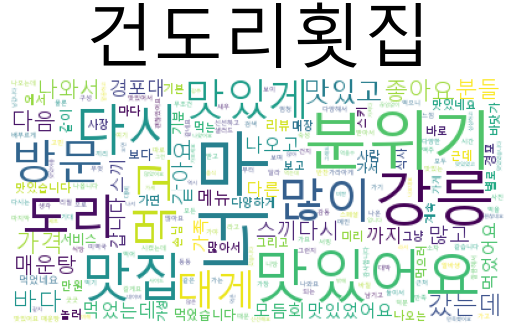

In [10]:

gen_wc_image('37765913')
    

---

# LDA (잠재 디리클레 할당)

In [12]:
tfidf_rslt_data_id_lst = os.listdir(TFIDF_DIR)
for tfidf_rslt_data_id in tfidf_rslt_data_id_lst:
    data_id = tfidf_rslt_data_id.replace('.csv','')
    market_name = market_master_df.query(f"(data_id == {data_id})")['market_name'].iloc[0]
    print(f'{data_id}: {market_name}')
    
    

11587704: 은파횟집
1167659600: 초당버거
11859878: 강릉짬뽕순두부 동화가든 본점
1401189515: 경포대 김군박군횟집
1731735004: 만동제과
1747803512: 해연가
37203388: 빅픽처6
37765913: 건도리횟집
998885728: 카페 툇마루


## LDA 입력에 쓰일 review text를 list로 만들기 

In [15]:
def get_review_text_to_list(data_id):
    review_df = pd.read_csv(f'{TFIDF_DIR}\\{data_id}.csv')
    review_all_lst = review_df['tfidf_text']
    split_to_lst = [review_line.split(' ') for review_line in review_all_lst]
    market_name_df = market_master_df.query(f"(data_id == {data_id})")['market_name']
    if not market_name.empty:
        market_name = market_name_df.iloc[0]
    else:
        market_name = ''

    return split_to_lst, market_name

In [16]:
from gensim import models
from gensim import corpora

# data_id를 바꿔가면서 실행해보세요.
splited_review_lst, market_name = get_review_text_to_list('1167659600')

In [24]:
dictionary = corpora.Dictionary(splited_review_lst)
print(dictionary)

Dictionary<8078 unique tokens: ['구이', '나오는', '도착', '많아', '맛집']...>


In [25]:
corpus = [dictionary.doc2bow(text) for text in splited_review_lst]
print(corpus[:3])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)], [(11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)], [(17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)]]


- LdaModel 클래스 파라미터의 의미는 아래를 참고한다. 
     * num_topics: 토픽의 개수(K) 지정 
     * passes: 학습 반복 횟수 (epochs와 동일한 의미)
     * iterations: 알고리즘 내 토픽을 결정하기 위한 반복 구간을 몇 번 반복할 것인지의 여부 

In [26]:
lda_model = models.ldamodel.LdaModel(corpus=corpus, 
                                     id2word=dictionary, 
                                     num_topics=5, 
                                     passes=5,
                                     iterations=10,
                                     random_state = 1)  

## 모델링 결과 토픽 확인하기 

In [20]:
lda_model.print_topics(num_words=7)

[(0,
  '0.042*"너무" + 0.038*"버거" + 0.013*"맛있고" + 0.013*"맛있게" + 0.011*"매장" + 0.009*"사장" + 0.008*"가게"'),
 (1,
  '0.025*"버거" + 0.020*"맛있어요" + 0.019*"분위기" + 0.018*"너무" + 0.013*"방문" + 0.010*"분들" + 0.010*"맛있고"'),
 (2,
  '0.028*"너무" + 0.025*"버거" + 0.018*"맛있어요" + 0.013*"맛있습니다" + 0.010*"강릉" + 0.009*"많고" + 0.009*"같아요"'),
 (3,
  '0.051*"버거" + 0.030*"맛있어요" + 0.024*"좋아요" + 0.021*"감자" + 0.016*"맛있었어요" + 0.016*"노스" + 0.014*"너무"'),
 (4,
  '0.052*"맛있어요" + 0.036*"강릉" + 0.026*"버거" + 0.016*"너무" + 0.015*"맛집" + 0.010*"다음" + 0.009*"가격"')]

## 문서 별 토픽 분포 확인하기

In [21]:
for idx, topic_list in enumerate(lda_model[corpus]):
    print(idx,'번째 문서의 topic 비율은',topic_list)
    if idx == 9:
        break

0 번째 문서의 topic 비율은 [(0, 0.015657794), (1, 0.015464689), (2, 0.015707022), (3, 0.015596076), (4, 0.93757445)]
1 번째 문서의 topic 비율은 [(2, 0.9631818), (3, 0.011553916)]
2 번째 문서의 topic 비율은 [(3, 0.17512414), (4, 0.7958192)]
3 번째 문서의 topic 비율은 [(0, 0.025295068), (1, 0.025348313), (2, 0.75493455), (3, 0.16894467), (4, 0.025477363)]
4 번째 문서의 topic 비율은 [(0, 0.014696445), (1, 0.013434417), (2, 0.01354691), (3, 0.013604586), (4, 0.94471765)]
5 번째 문서의 topic 비율은 [(0, 0.015477551), (1, 0.015559346), (2, 0.015886985), (3, 0.93760186), (4, 0.015474279)]
6 번째 문서의 topic 비율은 [(0, 0.033915464), (1, 0.03379066), (2, 0.033412624), (3, 0.03393062), (4, 0.8649506)]
7 번째 문서의 topic 비율은 [(3, 0.86037546), (4, 0.1131953)]
8 번째 문서의 topic 비율은 [(0, 0.14993882), (1, 0.029820273), (2, 0.17710057), (3, 0.61408913), (4, 0.029051263)]
9 번째 문서의 topic 비율은 [(0, 0.9648061)]


## pyLDAvis를 이용한 시각화 해보기
> 만약 pyLDAvis.gensim.prepare 메서드 실행시 아래 에러가 뜬다면 
> pip install "pandas<2.0.0" 명령으로 pandas 를 2.0 버전 미만 버전 설치할 것 (자동으로 현재 버전 삭제후 재설치)
>> BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [27]:
import pyLDAvis
import pyLDAvis.gensim
warnings.filterwarnings('ignore')

pyLDAvis.enable_notebook()
lda_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.show(lda_visualization, local=False)

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [04/Jul/2023 20:48:15] "GET / HTTP/1.1" 200 -



stopping Server...


## html 파일로 만들어두기 

In [43]:
html_dir = f'{PROJ_HOME}\\lda_html'
if not os.path.exists(html_dir):
    os.mkdir(html_dir)

html_path = f"{html_dir}\\{market_name.replace(' ','')}.html"
pyLDAvis.save_html(lda_visualization, html_path)

# LDA 모델 튜닝
## 토픽 개수별 Coherence와 perflexity 가져오기

In [91]:
from gensim.models import CoherenceModel 

coherence_lst=[]
perplexity_lst=[]
warnings.filterwarnings('ignore')

for i in range(2,21):
    
    lda_model_2 = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=i, iterations=10, passes=5)

    cm = CoherenceModel(model=lda_model_2, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print('num_topics', str(i))
    print("Coherence",coherence)
    coherence_lst.append(coherence)
    print('Perplexity: ', lda_model_2.log_perplexity(corpus),'\n\n')
    perplexity_lst.append(lda_model_2.log_perplexity(corpus))

Coherence -2.347410031294527
Perplexity:  -7.927954505475255 


Coherence -2.4982656683754025
Perplexity:  -7.972040271579934 


Coherence -2.5967231793355854
Perplexity:  -8.083101289166082 


Coherence -2.7796099000979657
Perplexity:  -8.134678839041113 


Coherence -3.11424643388138
Perplexity:  -8.151469762002908 


Coherence -3.692937417099659
Perplexity:  -8.234274925506224 


Coherence -3.977309870578929
Perplexity:  -8.23819629790853 


Coherence -5.009219533757828
Perplexity:  -8.373522473110032 


Coherence -4.108432405133524
Perplexity:  -8.671540165992345 


Coherence -3.871489176722517
Perplexity:  -8.995491706858898 


Coherence -5.862630690338912
Perplexity:  -9.364826375636111 


Coherence -5.08872676260257
Perplexity:  -9.633996634899779 


Coherence -6.206718516755701
Perplexity:  -9.924378166962844 


Coherence -6.533773936573377
Perplexity:  -10.25868798068399 


Coherence -7.340655585112247
Perplexity:  -10.48674979502394 


Coherence -7.370939063219001
Perplexity:

## Coherence, Perflexity 그래프로 확인하기 
- 확인 결과 토픽은 많을수록 좋지 않은 것을 볼 수 있음.
- 특정 마켓에 대한 리뷰만 모아 분석하였으므로 주제가 다양하지 못한 것에서 기인되는 것으로 추정 

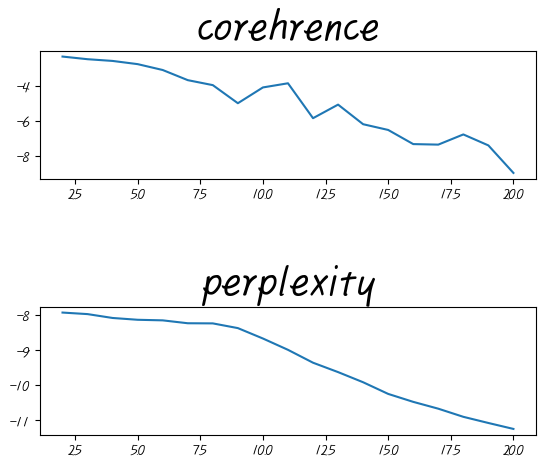

In [92]:
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

plt.subplot(2, 1, 1)
plt.plot(list(range(2,21)), coherence_lst)
plt.title('corehrence', fontsize = 30)

plt.subplot(2, 1, 2)
plt.plot(list(range(2,21)), perplexity_lst)
plt.title('perplexity', fontsize = 30)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=1)
plt.show()


## 수집된 리뷰 전체 데이터모델링
### TF-IDF 처리된 전체 데이터 가져오기 

In [23]:
splited_review_lst = []
market_all_review_lst = []

for tfidf_rslt_data_id in tfidf_rslt_data_id_lst:
    data_id = tfidf_rslt_data_id.replace('.csv','')
    review_df = pd.read_csv(f'{TFIDF_DIR}\\{data_id}.csv')
    review_all_lst = review_df['tfidf_text'].tolist()
    market_all_review_lst = market_all_review_lst + review_all_lst

splited_review_lst = [review_line.split(' ') for review_line in market_all_review_lst]
market_name = 'total'

print(splited_review_lst[:5])

[['구이', '나오는', '도착', '많아', '맛집', '먹었네요', '먹었어요', '물회', '배부르게', '생선', '싱싱하고'], ['가족', '같이', '다음', '만족', '먹었습니다', '부모님'], ['건조해져서', '넓고', '다만', '되어있어서', '맛있어요', '비추', '사진', '생각', '셋트이름', '신선하고요', '안나', '으로'], ['가자미'], ['맛있었어요']]


- passes 파라미터와 iterations 파라미터를 높여가면서 coherence와 perflexity 를 확인해보세요.